In [1]:
%load_ext autoreload

In [2]:
%autoreload
"""
A simple user interface for XMem
"""
import sys
sys.path.append('./xmem')

from argparse import ArgumentParser
import os
import torch
import numpy as np


from model.network import XMem
'''
from inference.interact.s2m_controller import S2MController
from inference.interact.fbrs_controller import FBRSController
from inference.interact.s2m.s2m_network import deeplabv3plus_resnet50 as S2M
'''

from inference.interact.resource_manager import ResourceManager
from inference.inference_core import InferenceCore

from demoutils.tools import *
import matplotlib.pyplot as plt
import cv2

#need install
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator,SamPredictor

torch.set_grad_enabled(False)
parser = ArgumentParser([])
parser.add_argument('--model', default='../data/saves_demo/XMem.pth')
parser.add_argument('--s2m_model', default='../data/saves_demo/s2m.pth')
parser.add_argument('--fbrs_model', default='../data/saves_demo/fbrs.pth')

parser.add_argument('--images', help='Folders containing input images.', default=None)
parser.add_argument('--video', help='Video file readable by OpenCV.', default="../data/valvedio/WIN_20230619_14_31_58_Pro.mp4")
parser.add_argument('--workspace', help='directory for storing buffered images (if needed) and output masks', default="../data/workspace/")

parser.add_argument('--buffer_size', help='Correlate with CPU memory consumption', type=int, default=100)
parser.add_argument('--num_objects', type=int, default=1)

# Long-memory options
# Defaults. Some can be changed in the GUI.
parser.add_argument('--max_mid_term_frames', help='T_max in paper, decrease to save memory', type=int, default=10)
parser.add_argument('--min_mid_term_frames', help='T_min in paper, decrease to save memory', type=int, default=5)
parser.add_argument('--max_long_term_elements', help='LT_max in paper, increase if objects disappear for a long time', 
                                                    type=int, default=10000)
parser.add_argument('--num_prototypes', help='P in paper', type=int, default=128) 

parser.add_argument('--top_k', type=int, default=30)
parser.add_argument('--mem_every', type=int, default=10)
parser.add_argument('--deep_update_every', help='Leave -1 normally to synchronize with mem_every', type=int, default=-1)
parser.add_argument('--no_amp', help='Turn off AMP', action='store_true')
parser.add_argument('--size', default=480, type=int, 
            help='Resize the shorter side to this size. -1 to use original resolution. ')
args = parser.parse_args(args=['--size', '480'])
config = vars(args)

In [3]:
#mask2former 模型
sys.path.append('./Mask2Former')
import tempfile
from pathlib import Path
import cog

# import some common detectron2 utilities
from detectron2.config import CfgNode as CN
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2.projects.deeplab import add_deeplab_config

# import Mask2Former project
from mask2former import add_maskformer2_config

from demoutils.tools import _create_text_labels

class Predictor(cog.Predictor):
    def setup(self):
        cfg = get_cfg()
        add_deeplab_config(cfg)
        add_maskformer2_config(cfg)
        cfg.merge_from_file("Mask2Former/configs/coco/instance-segmentation/swin/maskformer2_swin_small_bs16_50ep.yaml")
        cfg.MODEL.WEIGHTS = '../data/weightM2F/model_final_1e7f22.pkl'
        cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON = True
        cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON = True
        cfg.MODEL.MASK_FORMER.TEST.PANOPTIC_ON = True
        cfg.freeze()
        self.predictor = DefaultPredictor(cfg)
        self.metadata = MetadataCatalog.get(
            cfg.DATASETS.TEST[0] if len(cfg.DATASETS.TEST) else "__unused"
        )

    @cog.input(
        "image",
        type=Path,
        help="Input image for segmentation. Output will be the concatenation of Panoptic segmentation (top), "
             "instance segmentation (middle), and semantic segmentation (bottom).",
    )
    
    def predict(self, image):
        outputs = self.predictor(image)
        return outputs

In [4]:
%autoreload
import time

config['enable_long_term'] = True
config['enable_long_term_count_usage'] = True
config['dummyName'] = './test.mp4'
config['segPerson'] = True
config['segAll'] = False

class vedioSeg:
    def __init__(self, config):
        self.config = config
        self.network = XMem(config, args.model).cuda().eval()   
        #交互式时才需要，自动分割就不需要了
        '''
        s2m_saved = torch.load(args.s2m_model)
        self.s2m_model = S2M().cuda().eval()
        self.s2m_model.load_state_dict(s2m_saved)
        self.s2m_controller = S2MController(self.s2m_model, args.num_objects, ignore_class=255)
        self.fbrs_controller = FBRSController(args.fbrs_model)
        '''
        # IO管理器
        self.resource_manager = ResourceManager(config)
        self.height, self.width = self.resource_manager.h, self.resource_manager.w
        
        self.maskPredictor = None
        self.mask2Former = None
        #自动的mask生成，依赖SAM做语义分割，或者maskformer做实例分割
        if config['segAll']:
            model_type = "vit_t"
            sam_checkpoint = "../data/weightSAM/mobile_sam.pt"
            device = "cuda" if torch.cuda.is_available() else "cpu"
            mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
            mobile_sam.to(device=device)
            mobile_sam.eval()
            self.maskGen = SamAutomaticMaskGenerator(mobile_sam)
            self.maskPredictor = SamPredictor(mobile_sam)
        elif config['segPerson']:
            self.mask2Former = Predictor()
            self.mask2Former.setup()
            self.instanceTh = 0.8
        
        #初始化Xmem需要的变量
        self.firstFrame = None
        self.num_objects = 0
        self.cursur = 0
        self.current_image = np.zeros((self.height, self.width, 3), dtype=np.uint8) 
        self.current_image_torch = None
        self.current_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        self.current_prob = torch.zeros((self.num_objects, self.height, self.width), dtype=torch.float).cuda()
        
        #第一帧进行预分割，确定目标数量（TODO：改成动态数量，需要对mem维度做操作）
        self.determinceNumObj(no_mask=False)
        self.color_list = [np.random.randint(0,255,3,dtype=np.int32) for i in range(self.num_objects+1)] 
        self.cursur = 0

        #network, resource_manager, s2m_controller, fbrs_controller, config
        self.processor = InferenceCore(self.network, self.config)
        self.processor.set_all_labels(list(range(1, self.num_objects+1)))

        self.num_frames = len(self.resource_manager)
        print('====>all result will be scaled to:',self.height, self.width,' to process')
        print('====>number of frames:',self.num_frames)
        self.imgList = []
        self.dump = True
        self.dummyName = config['dummyName'] 
        
        
    def load_current_torch_image_mask(self, no_mask=False):
        if self.current_image_torch is None:
            self.current_image_torch, self.current_image_torch_no_norm = image_to_torch(self.current_image)

        if self.current_prob is None and not no_mask:
            self.current_prob = index_numpy_to_one_hot_torch(self.current_mask,self.num_objects+1).cuda()

    def show_current_mask_and_frame(self,mode,viz=True):
        plot_num = 2
        plt.subplot(1,plot_num,1)
        plt.imshow(self.current_image)
        canvas = torch.zeros((self.height, self.width, 3))
        if mode == 0:
            for i in range(1,self.current_prob.size(0)):
                bgr = self.color_list[i]
                tmp = self.current_prob[i,...].cpu().numpy()
                canvas[...,0][tmp>0.5] = bgr[0]
                canvas[...,1][tmp>0.5] = bgr[1]
                canvas[...,2][tmp>0.5] = bgr[2]
        elif mode == 1:
            canvas[:,:,0] = 255
            canvas[:,:,1] = 255
            canvas[:,:,2] = 255
            for i in range(1,self.current_prob.size(0)):
                tmp = self.current_prob[i,...].cpu().numpy()
                canvas[tmp>0.5] = torch.Tensor(self.current_image[tmp>0.5])
        if viz:
            plt.subplot(1,plot_num,2)
            plt.imshow(canvas/255.0)
            plt.show()
        self.imgList.append(np.concatenate([self.current_image,canvas],axis=1))
        
   
    #SAM 生成
    def mobilesamSeg(self, current_image):
        masks = self.maskGen.generate(current_image)
        self.current_mask *= 0
        #把生成的mask替换现在的mask
        for i in range(len(masks)):
            tmp = masks[i]['segmentation'].astype(np.uint8) * (i+1)
            self.current_mask[tmp>0.5] = tmp[tmp>0.5]
        print('numofobj:',self.num_objects)
        
    #mask2Former的实例分割
    def mask2FormerSeg(self,current_image):
        outputs = self.mask2Former.predict(image=current_image)
        predictions = outputs["instances"].to("cpu")
        boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
        scores = predictions.scores if predictions.has("scores") else None
        classes = predictions.pred_classes.tolist() if predictions.has("pred_classes") else None
        labels = _create_text_labels(classes, scores, self.mask2Former.metadata.get("thing_classes", None))
        keypoints = predictions.pred_keypoints if predictions.has("pred_keypoints") else None
        masks =  np.asarray(predictions.pred_masks)
        count = 1
        self.current_mask *= 0
        for i in range(len(masks)):
            score = scores[i]
            classid = classes[i]
            if score > self.instanceTh and classid ==0:
                mask = masks[i]
                self.current_mask[mask>0.5] = mask[mask>0.5] * count
                count += 1
                print(self.num_objects , np.max(self.current_mask),count)
    
    def manuallyUpdateMask(self):
        if config['segAll']:
            self.mobilesamSeg(self.current_image)
        elif config['segPerson']:
            self.mask2FormerSeg(self.current_image)
        else:
            raise ValueError("segmentor is not implied")
            
    #确定一下当前有多少个目标
    def determinceNumObj(self, no_mask=False):
        current_image = self.resource_manager.get_image(self.cursur)
        if not no_mask:
            if config['segAll']:
                masks = self.maskGen.generate(current_image)
                self.num_objects = len(masks) + 1
            elif config['segPerson']:
                outputs = self.mask2Former.predict(image=current_image)
                predictions = outputs["instances"].to("cpu")
                masks = np.asarray(predictions.pred_masks)
                count = 1
                scores = predictions.scores if predictions.has("scores") else None
                classes = predictions.pred_classes.tolist() if predictions.has("pred_classes") else None
                for i in range(len(masks)):
                    score = scores[i]
                    classid = classes[i]
                    if score > self.instanceTh and classid ==0:
                        mask = masks[i]
                        self.current_mask[mask>0] = mask[mask>0] * count
                        count += 1
                        print(np.max(self.current_mask),count)
                self.num_objects = count + 1
            else:
                raise ValueError("segmentor is not implied")

    def load_current_image_mask(self, no_mask=False):
        self.current_image = self.resource_manager.get_image(self.cursur)
        self.current_image_torch = None
        if not no_mask:
            self.manuallyUpdateMask()
            self.current_prob = None
            
    def segFromFirst(self):
        self.cursur  = 0
        showMode = 1
        self.imgList = []
        self.load_current_image_mask()
        self.load_current_torch_image_mask()
        #如果有存下来的musk就用，否则用sam筛一个
        self.show_current_mask_and_frame(mode=showMode)
        self.cursur = 0
        self.current_prob = self.processor.step(self.current_image_torch, self.current_prob[1:,...])
        self.current_mask = torch_prob_to_numpy_mask(self.current_prob)
        print('current_prob shape:',self.current_prob.shape)
        print('current_image_torch shape:',self.current_image_torch.shape)
        starttime = time.time()
        if self.dump:
            size = vos.imgList[0].shape[1],vos.imgList[0].shape[0]
            out = cv2.VideoWriter(self.dummyName,0x7634706d,30,size)
        try:
            while True:
                self.cursur = min(self.cursur+1, self.num_frames-1)
                self.current_image = self.resource_manager.get_image(self.cursur)

                #不去读mask，只读图片
                self.load_current_image_mask(no_mask=True)
                self.load_current_torch_image_mask(no_mask=True)
                self.current_prob = self.processor.step(self.current_image_torch)
                self.current_mask = torch_prob_to_numpy_mask(self.current_prob)

                #展示
                self.show_current_mask_and_frame(viz=(self.cursur%50==0),mode=showMode)
                frame = vos.imgList[-1][:,:,[2,1,0]]
                out.write((frame).astype(np.uint8))
                if(self.cursur%50==1):
                    endtime = time.time()
                    print('seg time cost:',endtime-starttime,'s', '50 pics', 50/(endtime-starttime),' fps')
                    starttime = time.time()
                if self.cursur == self.num_frames-1:
                    out.release()      
                    break
        except:
            out.release()      

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Workspace is in: ../data/workspace/
1228 images found.


/home/linyihan/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Weight format of MultiScaleMaskedTransformerDecoder have changed! Please upgrade your models. Applying automatic conversion now ...


1 2
2 3
3 4
====>all result will be scaled to: 480 853  to process
====>number of frames: 1228
5 1 2
5 2 3
5 3 4


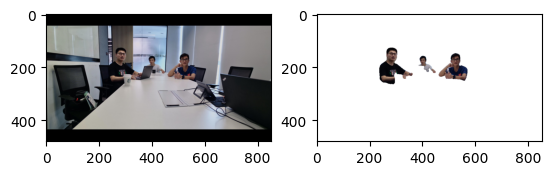

current_prob shape: torch.Size([6, 480, 853])
current_image_torch shape: torch.Size([3, 480, 853])
seg time cost: 0.08014869689941406 s 50 pics 623.84046072202  fps


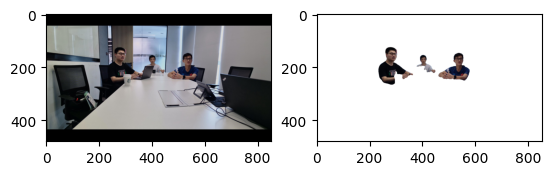

seg time cost: 4.4767327308654785 s 50 pics 11.168859747929064  fps


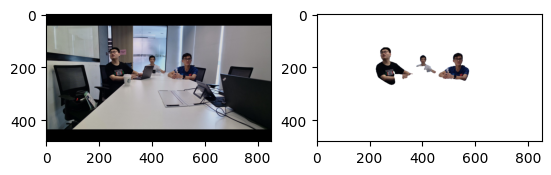

seg time cost: 5.757176399230957 s 50 pics 8.684812924384078  fps


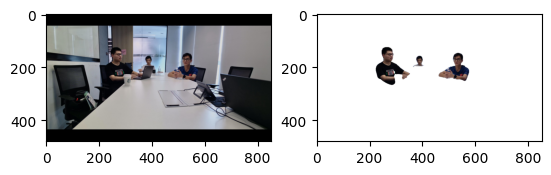

seg time cost: 5.6725640296936035 s 50 pics 8.81435621321681  fps


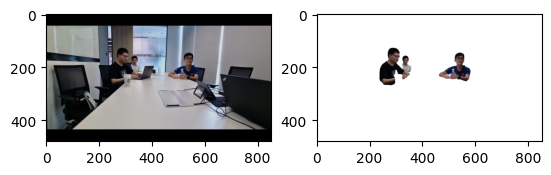

seg time cost: 4.511674165725708 s 50 pics 11.082360596835663  fps


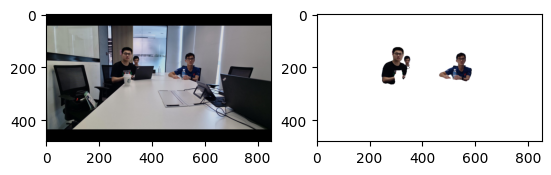

seg time cost: 4.537429571151733 s 50 pics 11.01945478512596  fps


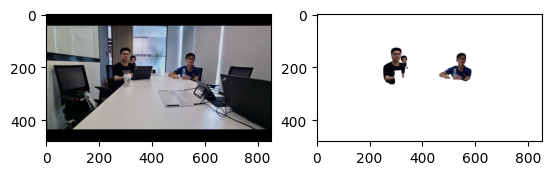

seg time cost: 4.506778240203857 s 50 pics 11.094399887254786  fps


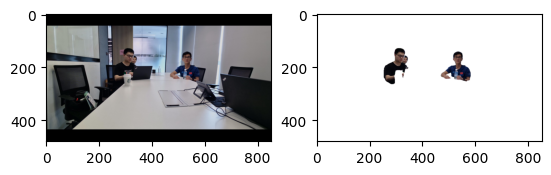

seg time cost: 4.484978675842285 s 50 pics 11.148325023108372  fps


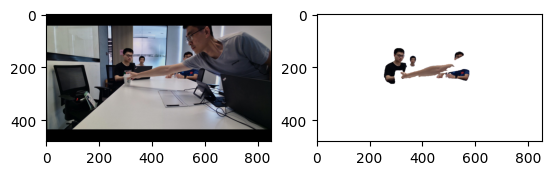

seg time cost: 4.5139007568359375 s 50 pics 11.076893953478939  fps


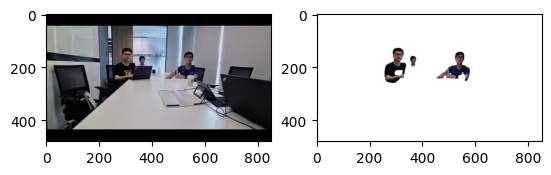

seg time cost: 4.530083179473877 s 50 pics 11.037324927399455  fps


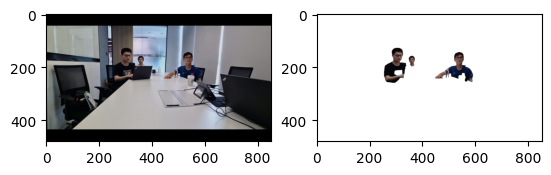

seg time cost: 4.510246515274048 s 50 pics 11.085868550792936  fps


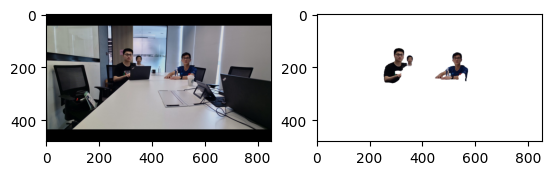

seg time cost: 4.51317024230957 s 50 pics 11.078686890927694  fps


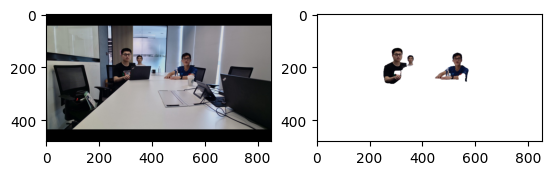

seg time cost: 4.737932920455933 s 50 pics 10.553125348002707  fps


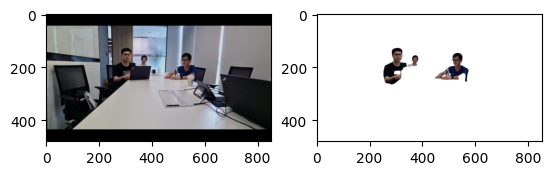

seg time cost: 4.512287139892578 s 50 pics 11.0808551073703  fps


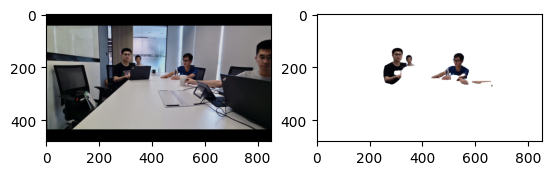

seg time cost: 4.531484365463257 s 50 pics 11.033912062253902  fps


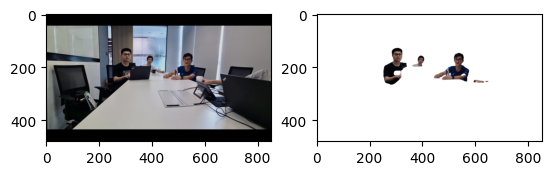

seg time cost: 4.5412352085113525 s 50 pics 11.01022028242187  fps


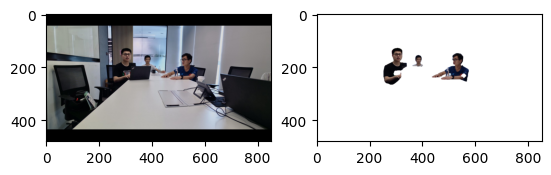

seg time cost: 4.5275678634643555 s 50 pics 11.043456775872938  fps


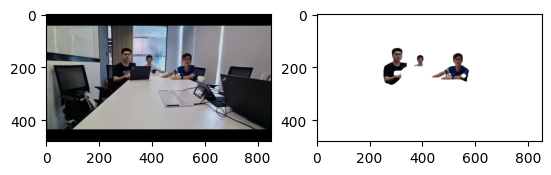

seg time cost: 4.5192201137542725 s 50 pics 11.063855873677122  fps


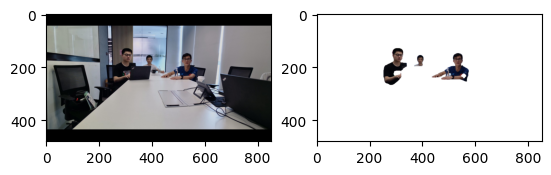

seg time cost: 4.533226728439331 s 50 pics 11.029671136085812  fps


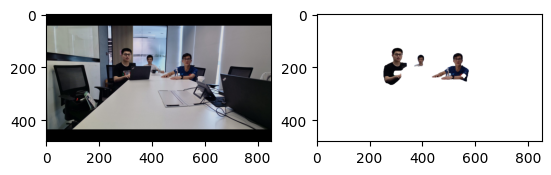

seg time cost: 4.524079084396362 s 50 pics 11.051973024178773  fps


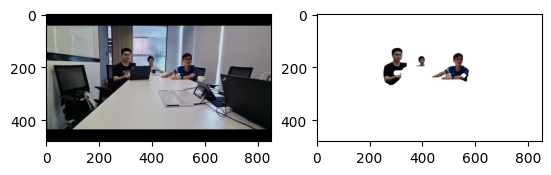

seg time cost: 4.53445291519165 s 50 pics 11.026688541077668  fps


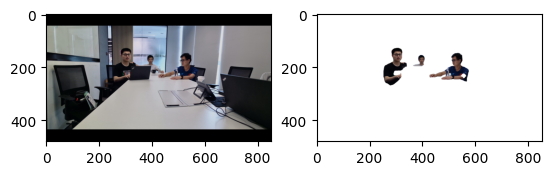

seg time cost: 4.702938795089722 s 50 pics 10.63165016142765  fps


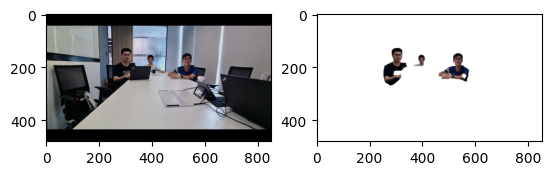

seg time cost: 4.549134016036987 s 50 pics 10.99110288325994  fps


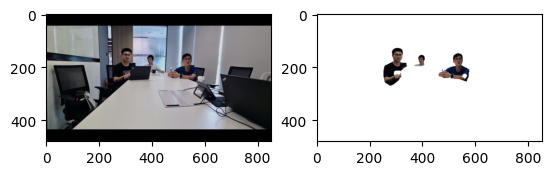

seg time cost: 4.560154914855957 s 50 pics 10.964539787258381  fps


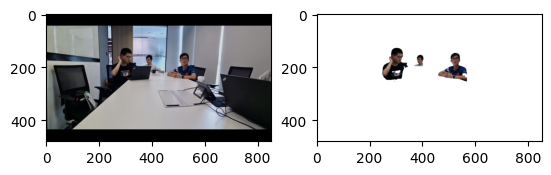

seg time cost: 4.553906202316284 s 50 pics 10.979584949415111  fps


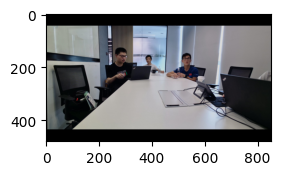

In [5]:
%autoreload
vos = vedioSeg(config)            
with torch.cuda.amp.autocast(enabled=not args.no_amp):
    vos.segFromFirst()
  